In [1]:
yes_dir=r"C:\Users\bhanu\Desktop\mini-2\Cancer-Prediction\Model_build\Brain tumor\brain_tumor_dataset\yes"
no_dir=r"C:\Users\bhanu\Desktop\mini-2\Cancer-Prediction\Model_build\Brain tumor\brain_tumor_dataset\no"

In [3]:
brain_model_dir=r"C:\Users\bhanu\Desktop\mini-2\Cancer-Prediction\Models"

In [1]:
import os
import cv2
import numpy as np
import pandas as pd

In [4]:
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Dropout,GlobalAveragePooling2D, Reshape, Dense, multiply, Add
from tensorflow.keras.utils import  to_categorical
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, RMSprop

In [6]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt

Loading data

In [7]:
def load_images_from_dir(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"): 
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize images to a fixed size
                images.append(img)
                labels.append(label)
    return images, labels

In [8]:
yes_images,yes_labels=load_images_from_dir(yes_dir,1)
no_images,no_labels=load_images_from_dir(no_dir,0)

In [9]:
images=yes_images+no_images
labels=yes_labels+no_labels

Applying CLAHE and Sharpening images

In [10]:
def apply_clahe(img):
    # Create a CLAHE object (clipLimit: threshold for contrast limiting, tileGridSize: size of grid for histogram equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img)
    return img_clahe

In [84]:
def apply_clahe_to_all(images):
    clahe_images = []
    for img in images:
        img_clahe = apply_clahe(img)
        clahe_images.append(img_clahe)
    return np.array(clahe_images)

In [12]:
clahe_images = apply_clahe_to_all(images)

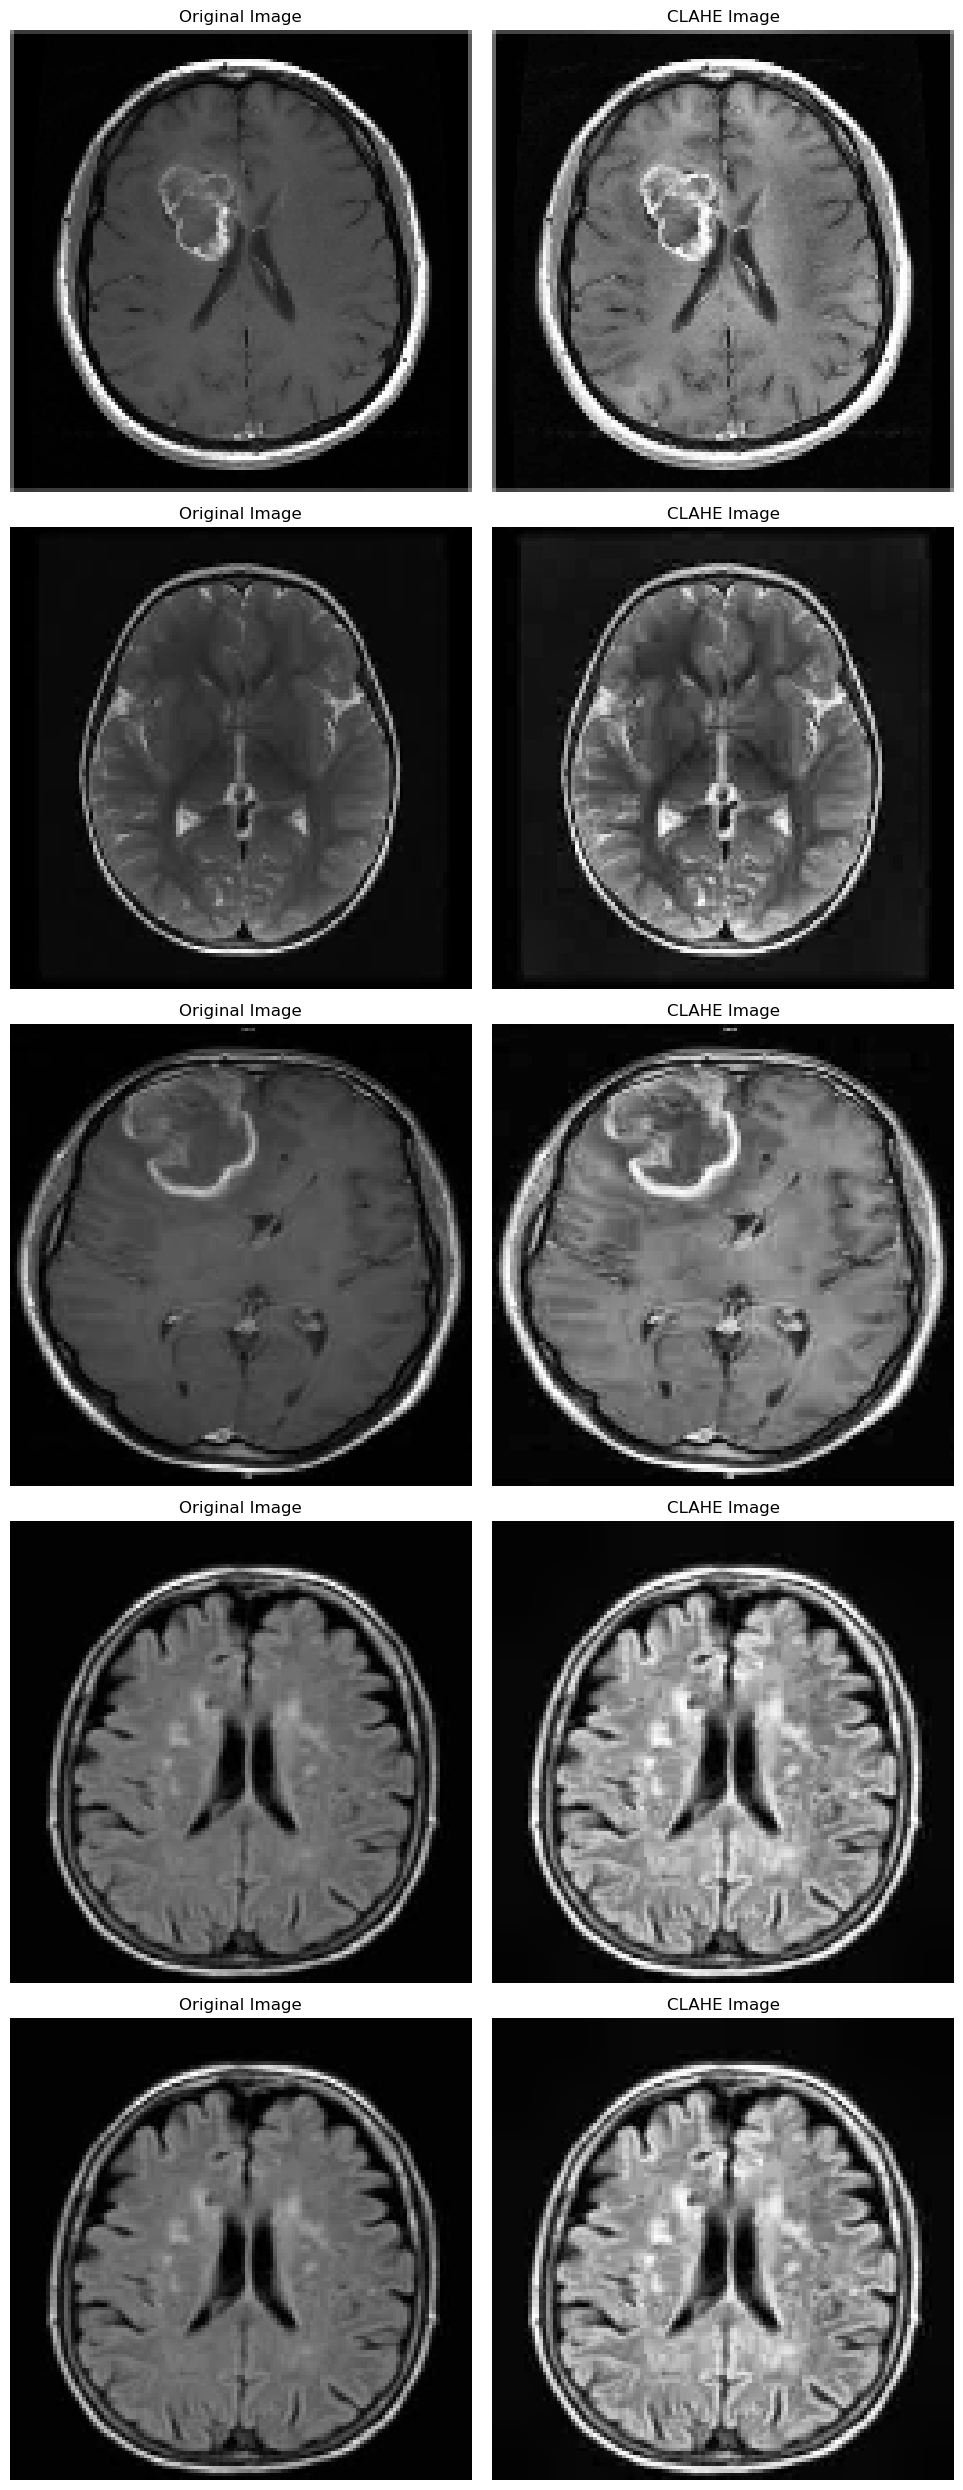

In [13]:
import random

def visualize_random_clahe_results(original_images, clahe_images, num_samples=5):
    # Ensure we don't sample more images than are available
    num_images = len(original_images)
    num_samples = min(num_samples, num_images)
    
    # Randomly select indices to visualize
    random_indices = random.sample(range(num_images), num_samples)
    
    # Set figure size
    plt.figure(figsize=(10, 5 * num_samples))
    
    for i, idx in enumerate(random_indices):
        # Original image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(original_images[idx], cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        # CLAHE applied image
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(clahe_images[idx], cmap='gray')
        plt.title("CLAHE Image")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visualization again with 5 random images
visualize_random_clahe_results(images, clahe_images)

In [14]:
def sharpen_image(image, alpha=1.5, beta=-0.5, gamma=0):
    """
    Sharpen an image using the Unsharp Mask technique.
    
    Parameters:
    - image: Input grayscale image.
    - alpha: Weight of the original image.
    - beta: Weight of the blurred image (typically negative).
    - gamma: Scalar added to the final image.
    
    Returns:
    - Sharpened image.
    """
    # Apply Gaussian blur to the image
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Sharpen the image using weighted addition
    sharpened_image = cv2.addWeighted(image, alpha, blurred_image, beta, gamma)
    
    return sharpened_image

In [15]:
def visualize_sharpened_images(original_images, clahe_images, num_samples=5):
    num_images = len(clahe_images)
    num_samples = min(num_samples, num_images)
    
    random_indices = random.sample(range(num_images), num_samples)
    
    plt.figure(figsize=(10, 8 * num_samples))
    
    for i, idx in enumerate(random_indices):
        # Original image
        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.imshow(original_images[idx], cmap='gray')
        plt.title("Original Image")
        plt.axis('off')
        
        # CLAHE image
        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.imshow(clahe_images[idx], cmap='gray')
        plt.title("CLAHE Image")
        plt.axis('off')
        
        # Sharpened CLAHE image
        sharpened_clahe_image = sharpen_image(clahe_images[idx])
        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.imshow(sharpened_clahe_image, cmap='gray')
        plt.title("Sharpened Image")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

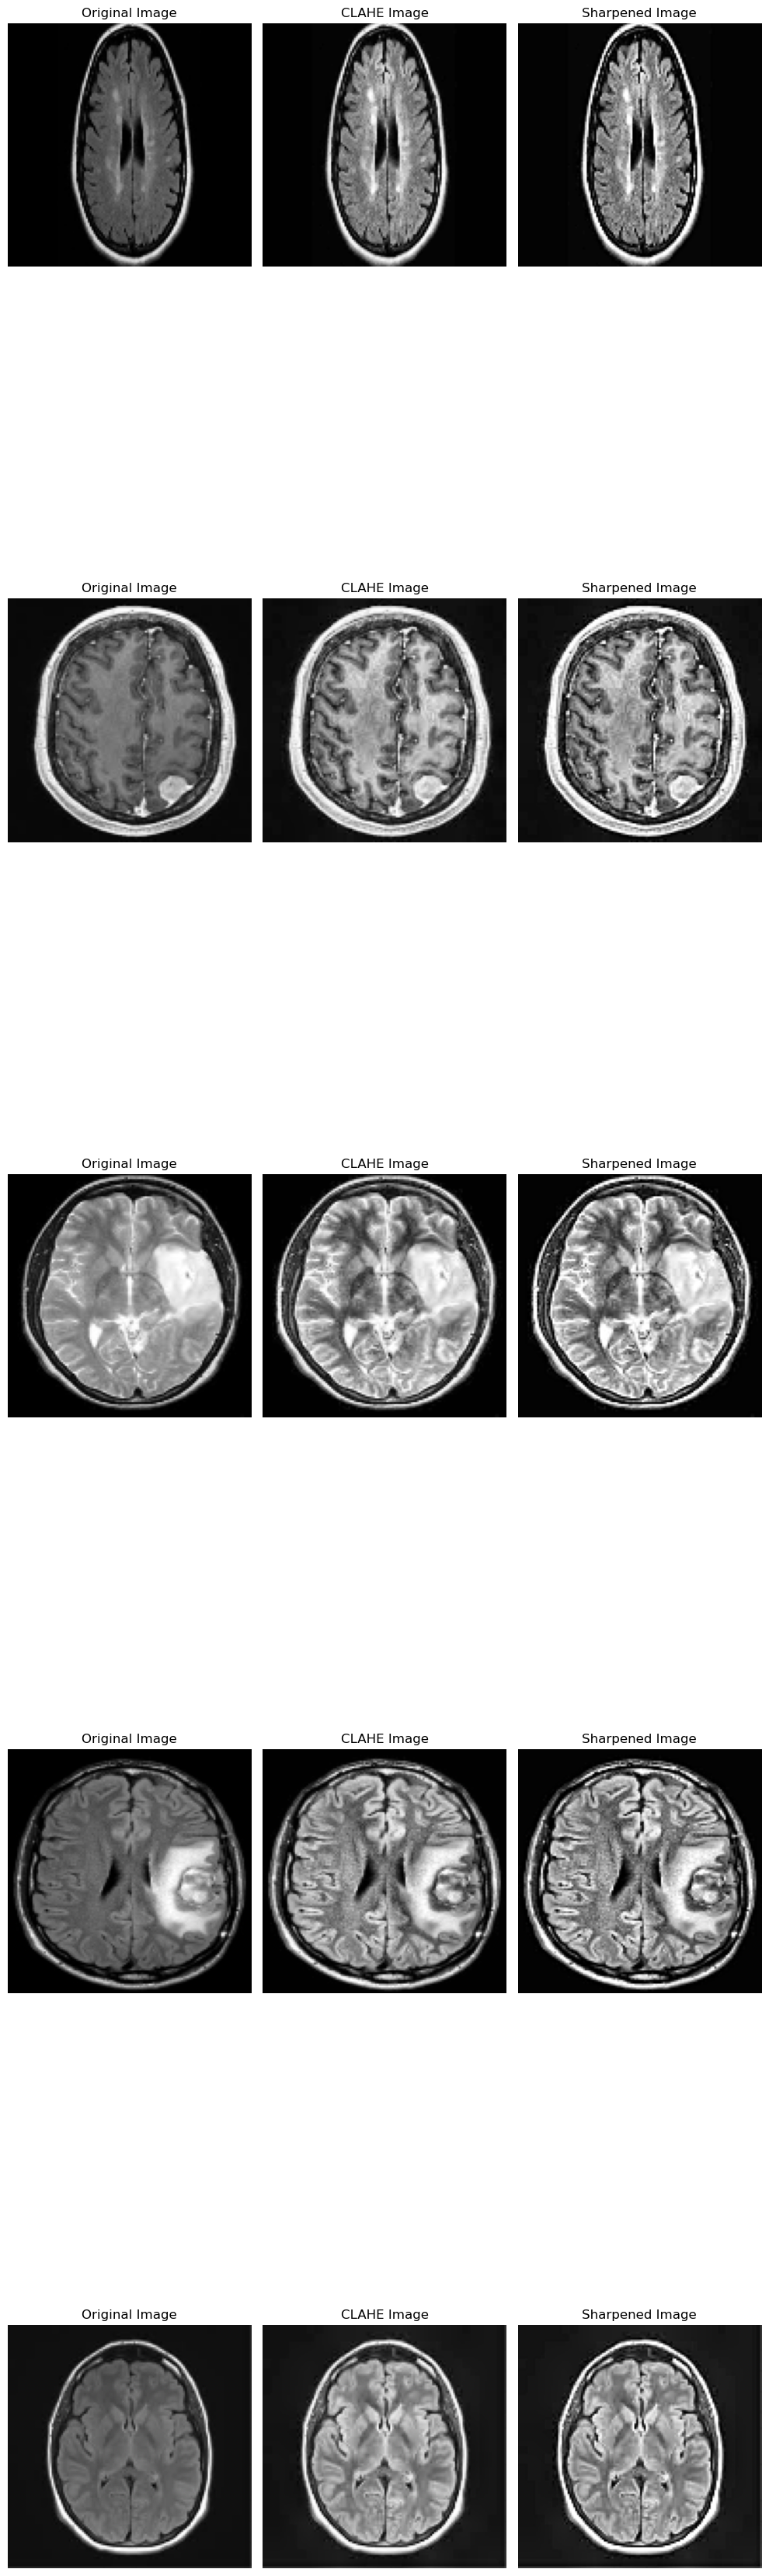

In [16]:
visualize_sharpened_images(images, clahe_images)

In [17]:
def apply_sharpening_to_dataset(dataset):
    """
    Apply the sharpening function to all images in the dataset.
    
    Parameters:
    - dataset: List of images (grayscale).
    
    Returns:
    - List of sharpened images.
    """
    sharpened_dataset = []
    for img in dataset:
        sharpened_img = sharpen_image(img)
        sharpened_dataset.append(sharpened_img)
    
    return sharpened_dataset

# Assuming `clahe_images` contains your CLAHE-processed images
sharpened_dataset = apply_sharpening_to_dataset(clahe_images)

In [18]:
images=np.array(images)
labels=np.array(labels)

In [19]:
sharpen_images=np.array(sharpened_dataset)

In [20]:
sharpen_images=sharpen_images.reshape(-1,128,128,1)

In [21]:
sharpen_images.shape

(173, 128, 128, 1)

In [22]:
images.shape

(173, 128, 128)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(sharpen_images, labels, test_size=0.2, random_state=42)

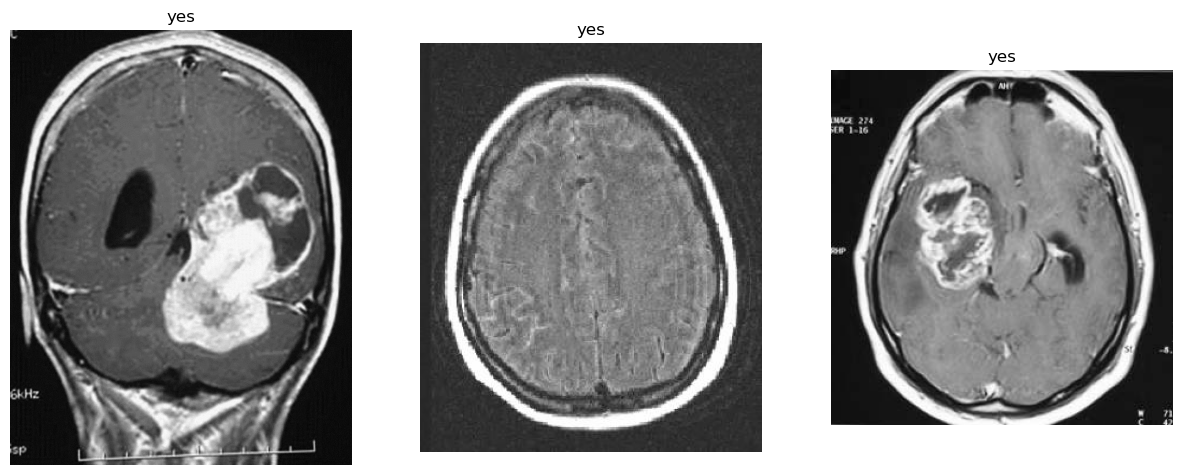

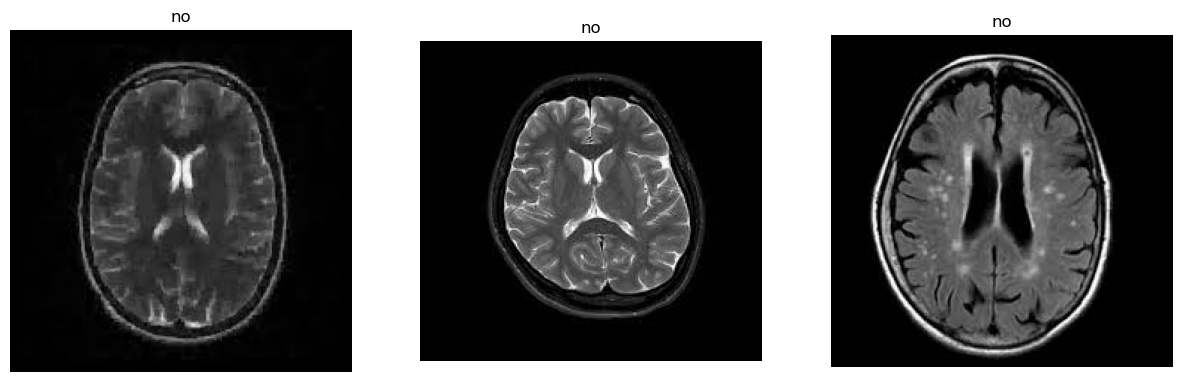

In [24]:
categories={
    "yes":yes_dir,
    "no":no_dir
}

for category, image_dir in categories.items():
    image_paths=[os.path.join(image_dir,filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpg','.png'))]
    fig, ax=plt.subplots(1,3,figsize=(15,15))
    ax=ax.ravel()
    for i,img_path in enumerate(np.random.choice(image_paths, size=3,replace=False)):
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(category)

    plt.show()

Model build

CNN-Model

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    restore_best_weights=True
)

In [26]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1,min_lr=0.001)

In [85]:
model1=Sequential([
    Conv2D(32,(2,2),activation='relu',input_shape=(128,128,1)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(100,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

In [86]:
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [87]:
y_train

array([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0])

In [88]:
X_train = np.array(X_train)

In [89]:
print("Shape of X_train:",X_train.shape)
print("Shape of y_train:",y_train.shape)

Shape of X_train: (138, 128, 128, 1)
Shape of y_train: (138,)


In [90]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 127, 127, 32)      160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 57600)             0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [91]:
history=model1.fit(X_train,y_train,epochs=16,batch_size=32,validation_split=0.2,validation_data=(X_test, y_test),callbacks=[lr_scheduler,early_stopping],verbose=1)
print("Training history:",history.history)

Epoch 1/16
5/5 [==============================] - 3s 343ms/step - loss: 138.7291 - accuracy: 0.5145 - val_loss: 39.1764 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/16
5/5 [==============================] - 1s 231ms/step - loss: 23.9697 - accuracy: 0.6957 - val_loss: 3.8903 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 3/16
5/5 [==============================] - 1s 234ms/step - loss: 3.4361 - accuracy: 0.7899 - val_loss: 0.7892 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/16
5/5 [==============================] - 1s 232ms/step - loss: 0.6539 - accuracy: 0.8116 - val_loss: 0.6238 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 5/16
5/5 [==============================] - 1s 233ms/step - loss: 0.3399 - accuracy: 0.8841 - val_loss: 0.5732 - val_accuracy: 0.6857 - lr: 0.0010
Epoch 6/16
5/5 [==============================] - 1s 238ms/step - loss: 0.1777 - accuracy: 0.9420 - val_loss: 0.5476 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 7/16
5/5 [==============================] - 1s 236ms/step - loss: 0.1328

In [92]:
history2=model1.fit(X_train,y_train,epochs=16,batch_size=32,validation_split=0.2,validation_data=(X_test, y_test),callbacks=[lr_scheduler],verbose=1)
print("Training history:",history2.history)

Epoch 1/16
5/5 [==============================] - 1s 250ms/step - loss: 0.6398 - accuracy: 0.8696 - val_loss: 1.5916 - val_accuracy: 0.6286 - lr: 0.0010
Epoch 2/16
5/5 [==============================] - 1s 239ms/step - loss: 0.4766 - accuracy: 0.8768 - val_loss: 0.6147 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 3/16
5/5 [==============================] - 1s 230ms/step - loss: 0.2487 - accuracy: 0.9420 - val_loss: 0.6484 - val_accuracy: 0.8286 - lr: 0.0010
Epoch 4/16
5/5 [==============================] - 1s 233ms/step - loss: 0.1872 - accuracy: 0.9420 - val_loss: 0.4869 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/16
5/5 [==============================] - 1s 230ms/step - loss: 0.1086 - accuracy: 0.9638 - val_loss: 0.6117 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 6/16
5/5 [==============================] - 1s 228ms/step - loss: 0.0563 - accuracy: 0.9638 - val_loss: 0.6980 - val_accuracy: 0.7714 - lr: 0.0010
Epoch 7/16
5/5 [==============================] - ETA: 0s - loss: 0.0544 - accurac

In [93]:
model1.save(os.path.join(brain_model_dir,"brain_tumor_model.h5"))

c:\Users\bhanu\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
